<a href="https://colab.research.google.com/github/bnguyen0847/BNMIS515_projects/blob/main/Project_3_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
import warnings
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

warnings.filterwarnings('ignore')

%autosave 60
sns.set(style='whitegrid', color_codes=True)

from google.colab import drive
drive.mount("/content/gdrive/")

Autosaving every 60 seconds
Mounted at /content/gdrive/


**Data Cleaning**

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Spring 2024/MIS 515/Project 3/CreditScoreClassification/train.csv')
df = df.drop(['ID','Customer_ID','SSN','Type_of_Loan','Monthly_Inhand_Salary','Credit_History_Age'], axis=1).dropna()

# ( r'\d+') captures one or more digits
df['Age'] = df['Age'].fillna('0').str.extract('(\d+)').astype(float).astype(int)
df['Num_of_Loan'] = df['Num_of_Loan'].fillna('0').str.extract('(\d+)').astype(float).astype(int)
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].fillna('0').str.extract('(\d+)').astype(float).astype(int)

#r'[^0-9.]' identifies whether it is a digit and removes any characters
df['Annual_Income'] = df['Annual_Income'].str.replace(r'[^0-9.]', '', regex=True)
df['Annual_Income'] = df['Annual_Income'].astype(float)

#cleaning up Credit limit column
df['Changed_Credit_Limit'] = df['Changed_Credit_Limit'].replace('_', np.nan)
df['Changed_Credit_Limit'] = pd.to_numeric(df['Changed_Credit_Limit'], errors='coerce')
df['Changed_Credit_Limit'] = df['Changed_Credit_Limit'].fillna(0)

#cleaning up amount invest monthly column
df['Amount_invested_monthly'] = df['Amount_invested_monthly'].astype(str)
df['Amount_invested_monthly'] = df['Amount_invested_monthly'].replace('', '0')
df['Amount_invested_monthly'] = df['Amount_invested_monthly'].str.replace(r'[^0-9.]', '')
df['Amount_invested_monthly'] = pd.to_numeric(df['Amount_invested_monthly'], errors='coerce')
df['Amount_invested_monthly'] = df['Amount_invested_monthly'].fillna(0)

#cleaning up monthly Balance column
df['Monthly_Balance'] = df['Monthly_Balance'].astype(str)
df['Monthly_Balance'] = df['Monthly_Balance'].str.replace(r'[^0-9.-]+', '')
df['Monthly_Balance'] = pd.to_numeric(df['Monthly_Balance'], errors='coerce')
df['Monthly_Balance'] = df['Monthly_Balance'].fillna(0)

#cleaning up Outstanding Debt column
df['Outstanding_Debt'] = df['Outstanding_Debt'].astype(str)
df['Outstanding_Debt'] = df['Outstanding_Debt'].str.replace(r'[^0-9.]', '', regex=True)
df['Outstanding_Debt'] = pd.to_numeric(df['Outstanding_Debt'], errors='coerce')
df['Outstanding_Debt'] = df['Outstanding_Debt'].fillna(0)

#filter out any columns with no values
df = df[df['Payment_Behaviour'] != '!@9#%8']
df = df[df['Occupation'] != '_______']
df = df[df['Credit_Mix'] != '_']

#removing any negative values
negative_nums = ['Delay_from_due_date', 'Changed_Credit_Limit', 'Num_Bank_Accounts']

for column in negative_nums:
    df = df[df[column] >= 0]

df

,Month,Name,Age,Occupation,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,...,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
2,March,Aaron Maashoh,500,Scientist,19114.12,3,4,3,4,3,...,4.0,Good,809.98,28.609352,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,Good
3,April,Aaron Maashoh,23,Scientist,19114.12,3,4,3,4,5,...,4.0,Good,809.98,31.377862,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,Good
6,July,Aaron Maashoh,23,Scientist,19114.12,3,4,3,4,3,...,4.0,Good,809.98,22.537593,No,49.574949,178.344067,Low_spent_Small_value_payments,244.565317,Good
9,February,Rick Rothackerj,28,Teacher,34847.84,2,4,6,1,7,...,2.0,Good,605.03,38.550848,No,18.816215,40.391238,High_spent_Large_value_payments,484.591214,Good
11,April,Rick Rothackerj,28,Teacher,34847.84,2,4,6,1,3,...,2.0,Good,605.03,39.182656,No,18.816215,99.306228,Low_spent_Medium_value_payments,465.676224,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99984,January,Sarah McBridec,28,Architect,20002.88,10,8,29,5,35,...,9.0,Bad,3571.70,22.895966,Yes,60.964772,43.370670,High_spent_Large_value_payments,328.655224,Poor
99985,February,Sarah McBridec,28,Architect,20002.88,10,8,29,5,33,...,9.0,Bad,3571.70,39.772607,Yes,12112.000000,148.275233,Low_spent_Small_value_payments,273.750662,Poor
99990,July,Sarah McBridec,28,Architect,20002.88,10,8,29,5,33,...,9.0,Bad,3571.70,25.123535,Yes,60.964772,173.275503,Low_spent_Large_value_payments,228.750392,Standard
99991,August,Sarah McBridec,29,Architect,20002.88,10,8,29,5,33,...,9.0,Bad,3571.70,37.140784,Yes,60.964772,34.662906,High_spent_Large_value_payments,337.362988,Standard


**Exploring Data**

In [ ]:
#changes Credit score into numeric value
credit_score_categories = ['Poor', 'Standard', 'Good']
encoder = OrdinalEncoder(categories=[credit_score_categories])
df['Credit_Score_Encoded'] = encoder.fit_transform(df[['Credit_Score']])

#converts Occupations into numerical values
label_encoder = LabelEncoder()
df['Occupation_Encoded'] = label_encoder.fit_transform(df['Occupation'])

#converts credit mix char into numerical value
credit_mix_categories = ['Bad', 'Standard', 'Good']
encoder = OrdinalEncoder(categories=[credit_mix_categories])
df['Credit_Mix_Encoded'] = encoder.fit_transform(df[['Credit_Mix']])

#payment behavior converted to numerical value
categories_payment_behaviour = [
    'Low_spent_Small_value_payments',
    'Low_spent_Medium_value_payments',
    'Low_spent_Large_value_payments',
    'High_spent_Small_value_payments',
    'High_spent_Medium_value_payments',
    'High_spent_Large_value_payments'
]
encoder_payment_behaviour = OrdinalEncoder(categories=[categories_payment_behaviour])
df['Payment_Behaviour_Encoded'] = encoder_payment_behaviour.fit_transform(df[['Payment_Behaviour']])

In [ ]:
print(df['Occupation'].unique())

['Scientist' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer' 'Lawyer'
 'Media_Manager' 'Doctor' 'Journalist' 'Manager' 'Accountant' 'Musician'
 'Mechanic' 'Writer' 'Architect']


In [ ]:
df = df[df['Age'] < 60]
df = df[df['Num_Credit_Card'] <= 10]
df = df[df['Interest_Rate'] <= 50]
df = df[df['Num_of_Loan'] <= 12]
df = df[df['Num_Bank_Accounts'] <= 10]
df = df[df['Delay_from_due_date'] <= 60]
df = df[df['Changed_Credit_Limit'] <= 30]
df = df[df['Num_Credit_Inquiries'] <= 12]
df = df[df['Total_EMI_per_month'] <= 200]
df = df[df['Outstanding_Debt'] <= 1500]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25243 entries, 3 to 99981
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Month                      25243 non-null  object 
 1   Name                       25243 non-null  object 
 2   Age                        25243 non-null  int64  
 3   Occupation                 25243 non-null  object 
 4   Annual_Income              25243 non-null  float64
 5   Num_Bank_Accounts          25243 non-null  int64  
 6   Num_Credit_Card            25243 non-null  int64  
 7   Interest_Rate              25243 non-null  int64  
 8   Num_of_Loan                25243 non-null  int64  
 9   Delay_from_due_date        25243 non-null  int64  
 10  Num_of_Delayed_Payment     25243 non-null  int64  
 11  Changed_Credit_Limit       25243 non-null  float64
 12  Num_Credit_Inquiries       25243 non-null  float64
 13  Credit_Mix                 25243 non-null  object 


In [ ]:
df.describe()

,Age,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_Score_Encoded,Occupation_Encoded,Credit_Mix_Encoded,Payment_Behaviour_Encoded
count,25243.000000,2.524300e+04,25243.000000,25243.000000,25243.000000,25243.000000,25243.000000,25243.000000,25243.000000,25243.000000,25243.000000,25243.000000,25243.000000,25243.000000,25243.000000,25243.000000,25243.000000,25243.000000,25243.000000
mean,35.081765,1.776723e+05,4.423761,4.811314,10.264113,2.236303,14.988234,29.290298,8.620277,3.917918,777.897675,32.541446,58.952833,186.415320,440.447608,1.097928,6.965733,1.414452,2.324605
std,11.025514,1.439214e+06,2.301428,1.674488,5.932230,1.704678,9.327510,228.505680,5.127740,2.815244,444.523185,5.125368,53.136855,188.029269,223.044562,0.606397,4.319482,0.535929,1.839686
min,14.000000,7.006520e+03,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.230000,21.502217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,2.212002e+04,3.000000,4.000000,6.000000,1.000000,8.000000,8.000000,4.550000,2.000000,389.910000,28.319210,16.366981,69.149057,294.273991,1.000000,3.000000,1.000000,0.000000
50%,35.000000,3.682324e+04,4.000000,5.000000,9.000000,2.000000,13.000000,11.000000,8.410000,4.000000,781.340000,32.544367,45.977299,127.086238,370.427686,1.000000,7.000000,1.000000,2.000000
75%,44.000000,7.367565e+04,6.000000,6.000000,14.000000,3.000000,22.000000,16.000000,11.640000,6.000000,1184.370000,36.735841,88.488889,231.638710,522.337144,1.000000,11.000000,2.000000,4.000000
max,56.000000,2.419806e+07,10.000000,10.000000,34.000000,9.000000,60.000000,4397.000000,26.900000,12.000000,1499.920000,49.564519,199.904691,1646.388176,1602.040519,2.000000,14.000000,2.000000,5.000000


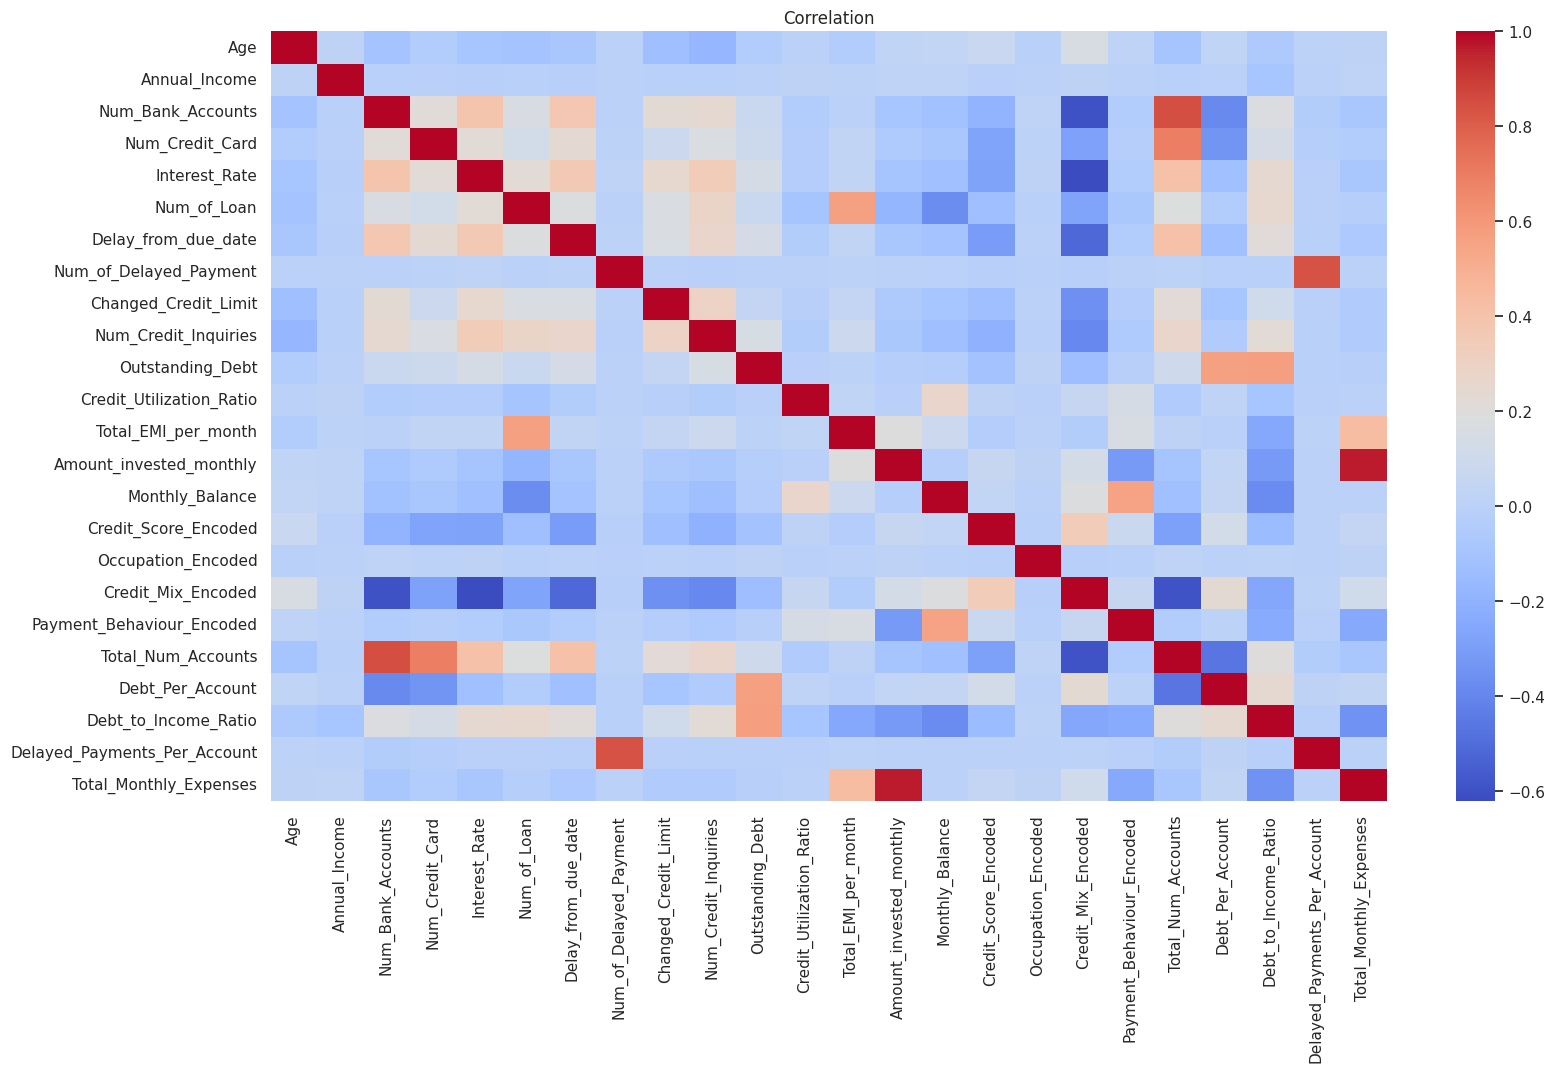

In [ ]:
#heatmap
plt.figure(figsize=(18, 10))
sns.heatmap(df.select_dtypes(include='number').corr(), cmap="coolwarm");
plt.title('Correlation')
plt.show()

In [ ]:
#boxplots
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

num_columns = 8
num_rows = (len(numeric_columns) + num_columns - 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, 6))

axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    sns.boxplot(x=df[column], ax=axes[i])
    axes[i].set_title(column, fontsize=7)
    axes[i].set_xlabel('Value', fontsize=7)
    axes[i].set_ylabel('Count', fontsize=7)

for j in range(len(numeric_columns), num_columns*num_rows):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

**Random Forest Model**

In [ ]:
Y = df['Credit_Score_Encoded']

X = df[['Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Total_EMI_per_month', 'Credit_Mix_Encoded']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=77)

In [ ]:
model = RandomForestRegressor(n_estimators=500, bootstrap=True, random_state=77)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, random_state=77)

In [ ]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error", mae)
print("Mean Squared Error:", mse)

Mean Absolute Error 0.27241428097001474
Mean Squared Error: 0.18124879336703364


In [ ]:
baseline_prediction = y_train.mean()
baseline_mse = mean_squared_error(y_test, [baseline_prediction] * len(y_test))

print("Baseline MSE:", baseline_mse)
print("MSE RFRegressor", mse)

Baseline MSE: 0.45051256986380633
MSE RFRegressor 0.1851849393286869


In [ ]:
estimator = model.estimators_[5]

In [ ]:
import sys
import matplotlib
matplotlib.use('Agg')

import pandas
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

dtree = DecisionTreeClassifier()
dtree = dtree.fit(X, Y)

features = ['Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Total_EMI_per_month', 'Credit_Mix_Encoded']

tree.plot_tree(dtree, feature_names=features)

plt.savefig(sys.stdout)
sys.stdout.flush()

�PNG

IHDR  �  �   5���   9tEXtSoftware Matplotlib version3.7.1, https://matplotlib.org/�
�   	pHYs  a  a�?�i  �6IDATx��{l�z����*RE��_([���ʲWZ{}Y_v�����I� �=i�-� A��U�A��i�C�"9@ڮ�m��n����׻�li-Y%�.Y�D��D�����v�̐rx)�� ��ř�}��<�|��d2�AAQ3H+ AAq�PHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHAQcPHġ'W:� �C���A£G�`6�!�J�����ׇ�������f3�<y�N�F�����]��n\�|KKK�X,p:��Z�������@��Dq`H��d��AA���Fcc#>��8�N���{�h4����p:����Css3Ξ=[�p	� *

In [ ]:
print("Decision Tree Accuracy:", dtree.score(X_train, y_train))

Decision Tree Accuracy: 0.9754877686441518


In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=500, bootstrap=True)
rf_classifier.fit(X_train, y_train)
print('Random Forest Accuracy:',rf_classifier.score(X_train, y_train))

Random Forest Accuracy: 0.9792017430920076


In [ ]:
y_pred = rf_classifier.predict(X_test)
matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(matrix, annot=True, cbar=False, linewidth=0.5, fmt="d", cmap = "OrRd")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for RandomForestClassifier on original test set')
plt.show()

NameError: name 'rf_classifier' is not defined

In [ ]:
print('\nClassification report for original test set:\n', classification_report(y_test, y_pred))


Classification report for original test set:
               precision    recall  f1-score   support

         0.0       0.76      0.77      0.77      3016
         1.0       0.79      0.79      0.79      5565
         2.0       0.73      0.71      0.72      1804

    accuracy                           0.77     10385
   macro avg       0.76      0.76      0.76     10385
weighted avg       0.77      0.77      0.77     10385

